### PREDICTIVE MAINTENANCE OF AIRCRAFT
In the predictive maintenance case study, you will have a data set containing 21 sensor data and three configuration setting values. The problem statement can be any of the following:

After how many cycles (number of flights) is the engine going to fail?
If the engine is going to fail before a certain number of cycles c.
If the engine is going to fail between a certain period of cycles c1 and c2?
For ease of understanding, we will be solving the second problem statement.

#### Import libraries

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
## setting seed for reproducability
np.random.seed(1234)
PYTHONHASHSEED=0

In [3]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM,GRU

#### Load the dataset
Download the dataset from Azure
1. Training Data
2. Test Data
3. Truth label for test data
We download the azuer dataset using wget command

In [4]:
## Data ingestion- reading the datasets from Azure blob
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2024-04-17 03:04:09--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  2.92MB/s    in 1.1s    

2024-04-17 03:04:11 (2.92 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2024-04-17 03:04:11--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.67, 13.107.213.67, 2620:1ec:bdf::67, ...
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.txt

#### PM_train.txt
1st column - Engine ID

2nd column - Number of engine cycles till failure.

In [5]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('PM_train.txt',sep=" ",header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('PM_test.txt',sep = ' ',header = None )

#Printing the first 5 values of train data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


### Let's drop the columns 26 and 27 since it contains NAN values.

In [6]:
train_df.dropna(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [7]:
#last two columns are not real
train_df.dropna(axis=1,inplace=True)
test_df.dropna(axis=1,inplace=True)

In [8]:
## Adding column names to the datasets
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

In [9]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
### Now we have to sort the values as per the ids first and then the number of cycles
train_df.sort_values(['id','cycle'],inplace=True)
test_df.sort_values(['id','cycle'],inplace=True)

### Loading the ground truth for the test data

In [11]:
truth_df = pd.read_csv('PM_truth.txt',sep=' ',header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [12]:
## dropping the NAN column
truth_df.dropna(axis=1,inplace=True)

#2.  DATA PREPARATION

Training set preprocessing
1. Calculate Remaining Useful Life(cycle)
2. Label the data for classification
3. Normalize the dataset

Calculate the remaining useful life

First we find maximum cycles observed for each engine using groupby() and then merge these values for respective engines data using merge()

Then calculate Remaining Useful Life(RUL) by subtracting the current cycle value from max. Eg- A cycle has total life of 192 cycles and it's already run 50 cycles currently hence it's RUL will be 192-50=142

In [13]:
#calculate max cycles for each engine id
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
#name the columns and merge it with the training data
rul.columns = ['id','max']
rul

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [14]:
train_df = train_df.merge(rul,on=['id'],how='left')

In [15]:
#now subtract the current cycle with max cycle to calculate remaining useful cycle
train_df['RUL'] = train_df['max']- train_df['cycle']
#dropping the irrelevant feature
train_df.drop('max',axis=1,inplace=True)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [16]:
rul.head()

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


Since we are interested in classification problem hence we will label the data according to our problem statement using numpy where() function.

In [17]:
# we'll make the lable which will indicate whether the engine is going to fail within w1 cycles?
w1= 30
train_df['failure_within_w1'] = np.where(train_df['RUL']<=w1,1,0)

Normalize the training dataset

For normalizing, some columns we don't want to consider. We leave these columns  using difference().
Then we normalize the values between 0 and 1 using MinMaxScaler(). and then join it with columns we left out previously using join(). Reindex() is using for reindexing the value  of the dataset starting from 0.


In [18]:
#making a separate feature for normalized value of cycle column
train_df['cycle_norm'] = train_df['cycle']

#Using difference function we leave out these column out of normalization
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

#MinMax normalization (from  0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df  =pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index = train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df  =join_df.reindex(columns=train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Normalize the test set similar to the training data

In [19]:
#MinMax normalization(from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns = cols_normalize,
                            index = test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Labeling the test set similarly we did for training data

In [20]:
#Let's calculate total RUL by summing up the maximum cycles iven in test set and ground truth additional RUL
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
truth_df.columns = ['additional_rul']

#id can be obtained by adding 1 in index as index starts from 0
truth_df['id'] = truth_df.index+1

#adding the max cycles given in test set and additional RUL given in ground truth dataframe
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul',axis=1,inplace=True)

#generate RUL for test data
test_df = test_df.merge(truth_df,on=['id'],how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max',axis=1,inplace=True)

#generate label columns w0 and w1 for test data
test_df['failure_within_w1'] = np.where(test_df['RUL']<=w1,1,0)


In [21]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


### DATA VISUALISATION

Let's see how the sensor values are changing for a particular engine id say id=1

<Axes: >

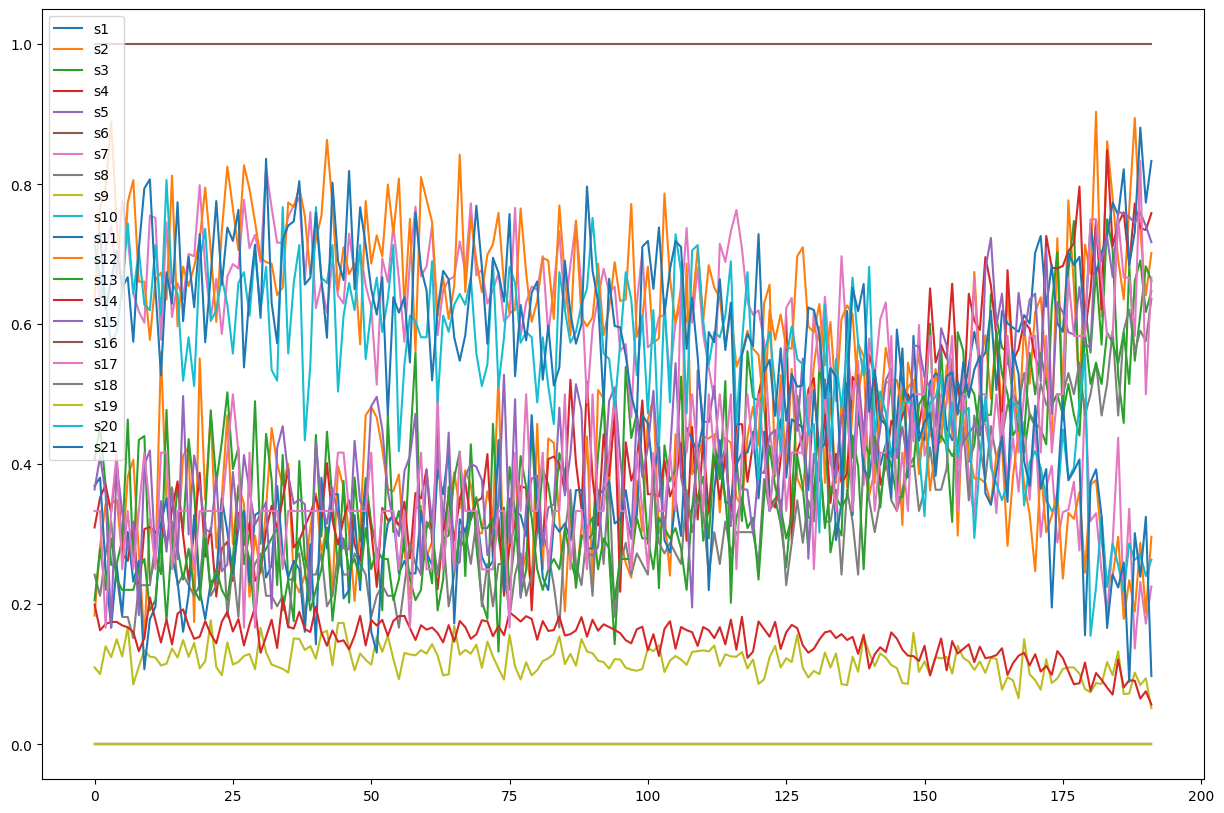

In [22]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(15,10))

You can see that most sensor values are following a trend as number of current cycles increases.

We can see that sensor2 values are increasing whereas sensor7 values are decreasing with increasing cycles.
We can find other such patterns as well, which will assist our model to capture the inherent relationship between the sensor values and the failure points.

<Axes: >

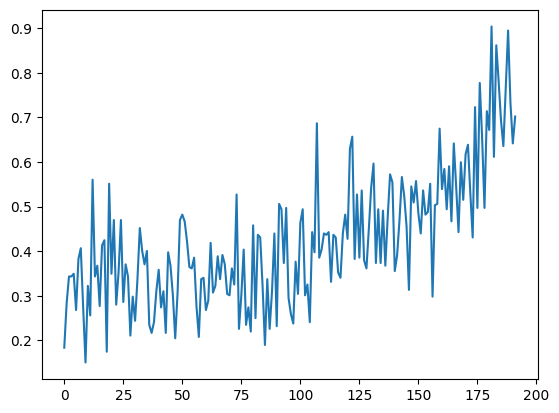

In [23]:
train_df[train_df.id==1][sensor_cols[1]].plot()

<Axes: >

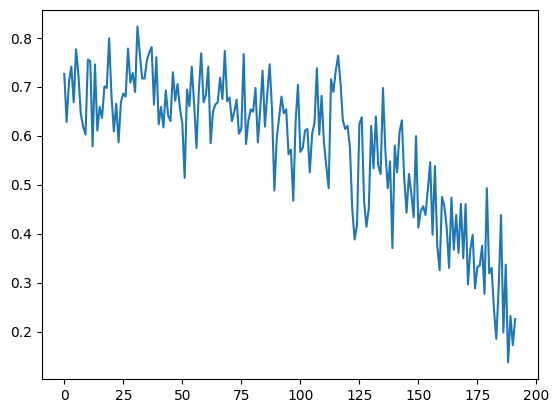

In [24]:
train_df[train_df.id==1][sensor_cols[6]].plot()

In [25]:
#sequence length to be used for predictions
sequence_length = 50

In [26]:
#function to generate sequences of shape(samples,time steps, features) for a particular engine id

def sequence_generator(feature_df,seq_length,seq_cols):
  # we will not be using any sequence which is below seq_length
  # convert the dataframe into numpy 2d array
  feature_array = feature_df[seq_cols].values
  num_elements = feature_array.shape[0]

  # we want to generate sequences of 50 time steps at a time
  # hence iterate over two sets of indices(0,142),(50,192)
  # for eg: id1 have 192 rows and sequence_length
  # 0 50 --> from row 0 to row 50
  # 1 51 --> from row 1 to row 51
  # 2 52 --> from row 2 to row 52
  # ....
  # 141 191 --> from row 111 to 191
  for start,stop in zip(range(0,num_elements-seq_length),range(seq_length,num_elements)):
    yield feature_array[start:stop,:]

In [27]:
# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1','setting2','setting3','cycle_norm']
sequence_cols.extend(sensor_cols) # add the elements of sensor_cols into sequence_cols

In [28]:
# generate sequnces for each engine id
# unique() returns all the unique ids in a list
seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# concatenate sequences of different engine ids into one and convert to numpy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)]
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# the shape denotes (number of samples, number of time steps, number of features)
seq_set.shape


(15631, 50, 25)

In [29]:
# function to generate labels
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # convert the labels to the numpy 2d array
    label_array = label_df[label].values
    num_elements = label_array.shape[0]
    # Remove the first label since the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [30]:
# generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1)
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

# 3. MODEL BUILDING

In [31]:
# Model - (100 LSTM units with 0.2 dropout) +
#         (50 LSTM units with 0.2 dropout) +
#         (dense layer with sigmoid activation)

features_dim = seq_set.shape[2] # number of features
out_dim = label_set.shape[1] # sequence length

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# define path to save model
model_path = 'binary_model.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

Also note that the number of features that we pass in the model is nothing but the number of columns of our dataset which act as features basically. As you can see in the notebook, we have 21 sensors’ data + 3 settings configuration + normalised number of cycles at current time step = total 25 features. All of these features are treated as a separate time series and RNN model also trains on the inter-related patterns between these features.



As per the equation we have studied also, let's calculate the parameters:
#### 1st layer
Input weights = num layersXnum featuresXnum units(outputs) = 4X25X100=10000

Recurrent weights = num layersXnum unitsXnum units = 4X100X100 = 40000

Biases = num layersXnum units = 4X100 = 400

Total Parameters = 50400

#### 2nd layer
num features = 100
num _units = 50
Input weights = 4X100X50 = 20000
Recurrent weights = 4X50X50 = 10000
Biases = 4*50 = 200
Total Params = 30200

# 4. MODEL EVALUATION

Let's fit the model with batch size of 200 and for 200 epochs. we'll save the best model weights using ModelCheckpoint and also using EarlyStopping to prevent overfitting.

In [32]:
import time
epochs = 200
batch_size = 200
start = time.time()

# fit the network
history = model.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 7s - loss: 0.2636 - accuracy: 0.8847 - val_loss: 0.0699 - val_accuracy: 0.9719 - 7s/epoch - 99ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 1s - loss: 0.0918 - accuracy: 0.9640 - val_loss: 0.0516 - val_accuracy: 0.9795 - 610ms/epoch - 8ms/step
Epoch 3/200
75/75 - 1s - loss: 0.0802 - accuracy: 0.9670 - val_loss: 0.0492 - val_accuracy: 0.9821 - 605ms/epoch - 8ms/step
Epoch 4/200
75/75 - 1s - loss: 0.0743 - accuracy: 0.9691 - val_loss: 0.0558 - val_accuracy: 0.9783 - 629ms/epoch - 8ms/step
Epoch 5/200
75/75 - 1s - loss: 0.0730 - accuracy: 0.9698 - val_loss: 0.0411 - val_accuracy: 0.9859 - 613ms/epoch - 8ms/step
Epoch 6/200
75/75 - 1s - loss: 0.0589 - accuracy: 0.9759 - val_loss: 0.0348 - val_accuracy: 0.9872 - 610ms/epoch - 8ms/step
Epoch 7/200
75/75 - 1s - loss: 0.0587 - accuracy: 0.9759 - val_loss: 0.0672 - val_accuracy: 0.9706 - 654ms/epoch - 9ms/step
Epoch 8/200
75/75 - 1s - loss: 0.0587 - accuracy: 0.9756 - val_loss: 0.0386 - val_accuracy: 0.9808 - 612ms/epoch - 8ms/step
Epoch 9/200
75/75 - 1s - loss: 0.0570 - accuracy: 0.9773 - val_loss: 0.0486 - val_accuracy: 0.9783 - 665ms/epoch - 9ms/step
Epoch 10/200
75/75 -

# 5. MODEL EVALUATION ON VALIDATION SET

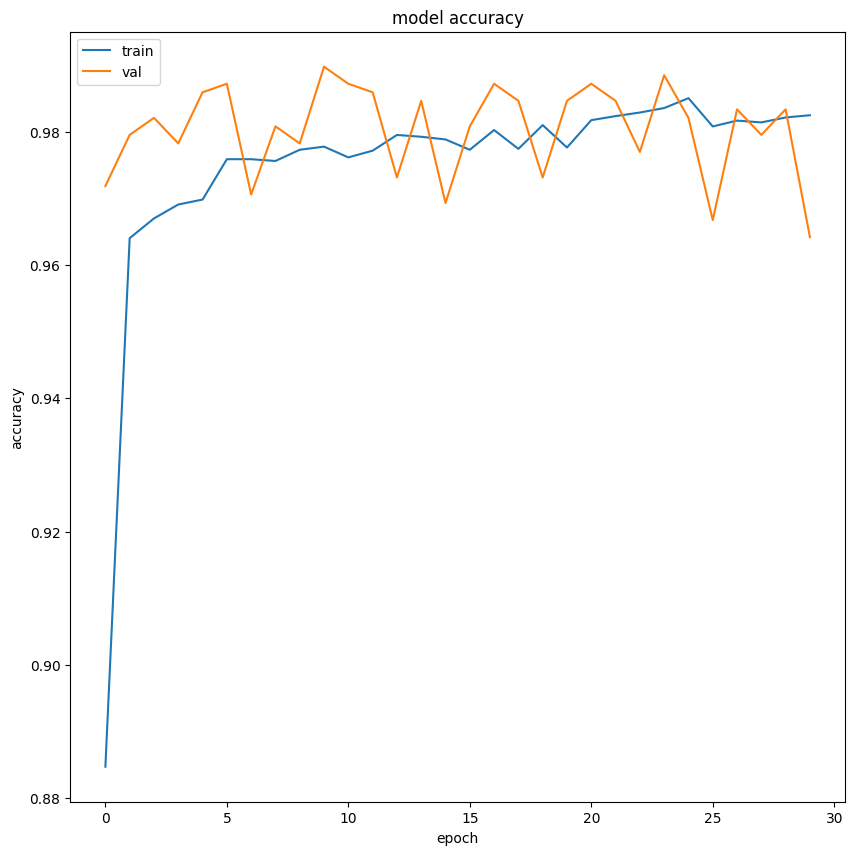

In [33]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

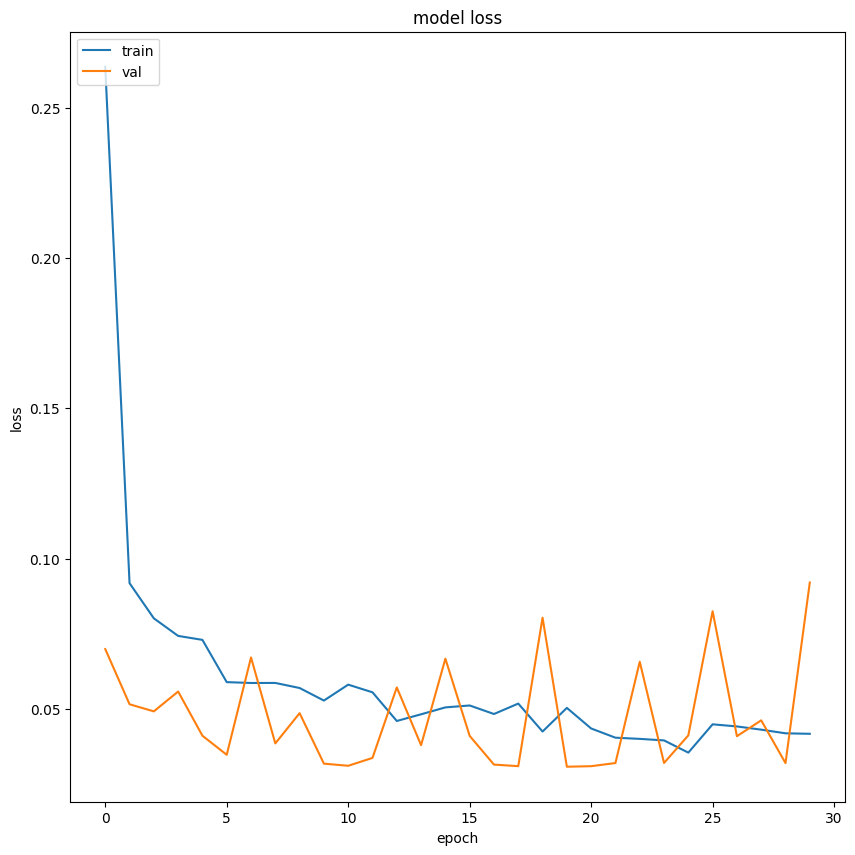

In [34]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

In [42]:
# training metrics
scores = model.evaluate(seq_set, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict(seq_set, verbose=1, batch_size=200)
y_pred = np.argmax(y_pred, axis=-1)  # Obtain the class with the highest probability

# Convert y_true to array if it's not already
y_true = np.array(label_set)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 1s 4ms/step - loss: 0.0792 - accuracy: 0.9655
Train Accurracy: 0.9654532670974731
79/79 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12531     0]
 [ 3100     0]]
Train Precision =  0.0 
 Train Recall =  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MODEL EVALUATION ON TEST SET

3/3 - 1s - loss: 0.0596 - accuracy: 0.9677 - 770ms/epoch - 257ms/step
Total time taken for inferencing:  0.82  secs
Test Accurracy: 0.9677419066429138
3/3 [==============================] - 1s 5ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [25  0]]
Test Precision:  0.0 
 Test Recall:  0.0 
 Test F1-score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-46-7f18c48f809a>:42: RuntimeWarning: invalid value encountered in scalar divide
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)


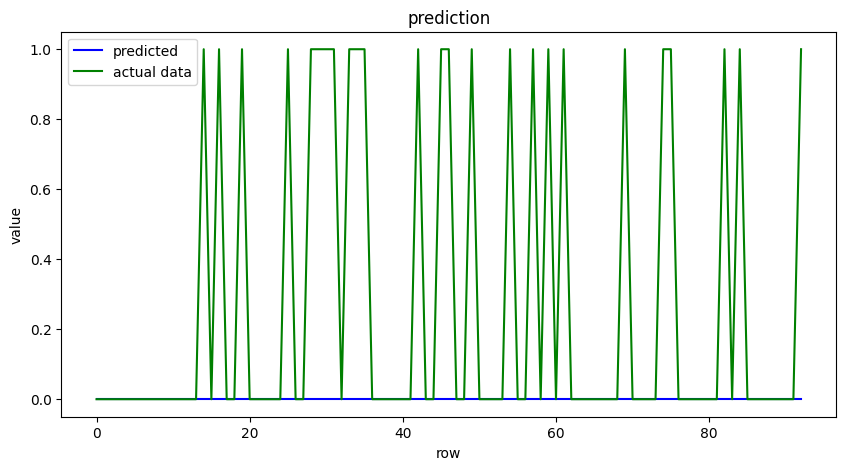

In [46]:
# considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# if best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict(last_test_seq)
y_pred_test = np.argmax(y_pred_test, axis=-1)

# Convert y_true_test to array if it's not already
y_true_test = np.array(last_test_label)


test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

In [47]:

print(features_dim)

25


# New Section